In [ ]:
#| default_exp data

# Data functionalities

> Generating and importing data

In [ ]:
#| export
from functools import partial
from types import SimpleNamespace
from torchvision.datasets import MNIST

In [ ]:
PATH = "."

In [ ]:
mnist = MNIST(PATH, download=True)
mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train

In [ ]:
mnist.data.shape

torch.Size([60000, 28, 28])

## Visualizing the dataset

In [ ]:
from torch_moving_mnist.utils import show_image, show_images

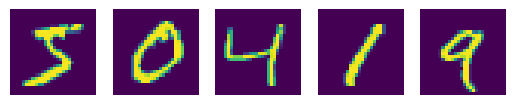

In [ ]:
show_images(mnist.data[0:5]);

## Generating moving mnist sequences:

In [ ]:
#| export
import random

import torch
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

mnist_stats    = ([0.131], [0.308])

We can leverage torchvision's affine transform!

In [ ]:
digit = torch.tensor(mnist.data[[0]])

<AxesSubplot: >

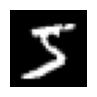

In [ ]:
show_image(digit)

In [ ]:
angle = 12  # rotation in degrees
scale = 1.3 # scaling in percentage (1.0 = no scaling)
translate = (2,3) # translation in pixels
shear = 15 # deformation on the z-plane

<AxesSubplot: >

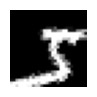

In [ ]:
show_image(TF.affine(digit, angle, translate, scale, shear))

we should probably pad first, so we don't get out of the canvas

In [ ]:
#| export
def padding(img_size=64, mnist_size=28): return (img_size - mnist_size) // 2

In [ ]:
padding(64)

18

<AxesSubplot: >

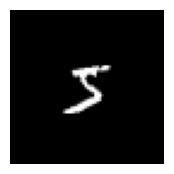

In [ ]:
pdigit = TF.pad(digit, padding=18)  #18 give us a 64x64 image (18x2 + 28)
show_image(pdigit)

<AxesSubplot: >

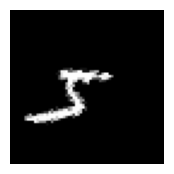

In [ ]:
tf = partial(TF.affine, angle=angle, translate=(-7,3), scale=scale, shear=shear)
show_image(tf(pdigit))

applying recursively

In [ ]:
#| export
def apply_n_times(tf, x, n=1):
    "Apply `tf` to `x` `n` times, return all values"
    sequence = [x]
    for n in range(n):
        sequence.append(tf(sequence[n]))
    return sequence

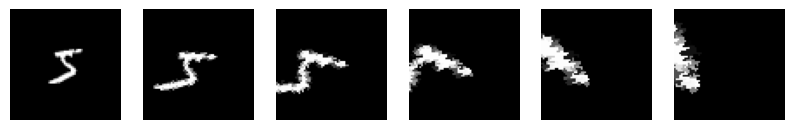

In [ ]:
show_images(apply_n_times(tf, pdigit, n=5), figsize=(10,20))

Let's define some limits to the parameters:

In [ ]:
#| export
affine_params = SimpleNamespace(
    angle=(-4, 4),
    translate=((-5, 5), (-5, 5)),
    scale=(.8, 1.2),
    shear=(-3, 3),
)

we can sample from these values using `random.uniform`

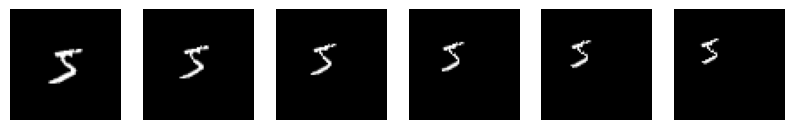

In [ ]:
angle     = random.uniform(*affine_params.angle)
translate = (random.uniform(*affine_params.translate[0]), 
             random.uniform(*affine_params.translate[1]))
scale     = random.uniform(*affine_params.scale)
shear     = random.uniform(*affine_params.shear)

tf = partial(TF.affine, angle=angle, translate=translate, scale=scale, shear=shear)

show_images(apply_n_times(tf, pdigit, n=5), figsize=(10,20))

In [ ]:
#| export
class RandomTrajectory:
    def __init__(self, affine_params, n=5, **kwargs):
        self.angle     = random.uniform(*affine_params.angle)
        self.translate = (random.uniform(*affine_params.translate[0]), 
                          random.uniform(*affine_params.translate[1]))
        self.scale     = random.uniform(*affine_params.scale)
        self.shear     = random.uniform(*affine_params.shear)
        self.n = n
        self.tf = partial(TF.affine, angle=self.angle, translate=self.translate, scale=self.scale, shear=self.shear, **kwargs)
            
    def __call__(self, img):
        return apply_n_times(self.tf, img, n=self.n)
    
    def __repr__(self):
        s = ("RandomTrajectory(\n"
             f"  angle:     {self.angle}\n"
             f"  translate: {self.translate}\n"
             f"  scale:     {self.scale}\n"
             f"  shear:     {self.shear}\n)")
        return s

RandomTrajectory(
  angle:     -2.3709038276158987
  translate: (4.3894320961193625, -0.3797481392135005)
  scale:     1.153061156734955
  shear:     1.4684735951046202
)


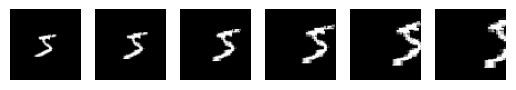

In [ ]:
traj = RandomTrajectory(affine_params)
print(traj)
show_images(traj(pdigit))

One extra thing we need to do is randomly place the image on the canvas

In [ ]:
move = partial(TF.affine, angle=0, scale=1, shear=(0,0))

In [ ]:
def random_place(img, img_size=64):
    "Randomly place the digit inside the canvas"
    max_displacement = padding(img_size)
    x = random.uniform(-max_displacement, max_displacement)
    y = random.uniform(-max_displacement, max_displacement)
    return move(img, translate=(x,y))

<AxesSubplot: >

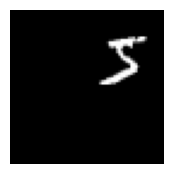

In [ ]:
show_image(random_place(pdigit))

In [ ]:
#| export
import math
import random
from fastprogress import progress_bar

class MovingMNIST:
    def __init__(self, path=".",  # path to store the MNIST dataset
                 affine_params: dict=affine_params, # affine transform parameters, refer to torchvision.transforms.functional.affine
                 num_digits: list[int]=[1,2], # how many digits to move, random choice between the value provided
                 num_frames: int=4, # how many frames to create
                 img_size=64, # the canvas size, the actual digits are always 28x28
                 concat=True, # if we concat the final results (frames, 1, 28, 28) or a list of frames.
                 normalize=False # scale images in [0,1] and normalize them with MNIST stats. Applied at batch level. Have to take care of the canvas size that messes up the stats!
                ):
        self.mnist = MNIST(path, download=True).data
        self.affine_params = affine_params
        self.num_digits = num_digits
        self.num_frames = num_frames
        self.img_size = img_size
        self.pad = padding(img_size)
        self.concat = concat
        
        # some computation to ensure normalizing correctly-ish
        batch_tfms = [T.ConvertImageDtype(torch.float32)]
        if normalize:
            ratio = (28/img_size)**2*max(num_digits)
            mean, std = mnist_stats
            scaled_mnist_stats = ([mean[0]*ratio], [std[0]*ratio])
            print(f"New computed stats for MovingMNIST: {scaled_mnist_stats}")
            batch_tfms += [T.Normalize(*scaled_mnist_stats)] if normalize else []
        self.batch_tfms = T.Compose(batch_tfms)  
    
    def random_place(self, img):
        "Randomly place the digit inside the canvas"
        x = random.uniform(-self.pad, self.pad)
        y = random.uniform(-self.pad, self.pad)
        return TF.affine(img, translate=(x,y), angle=0, scale=1, shear=(0,0))
    
    def random_digit(self):
        "Get a random MNIST digit randomly placed on the canvas"
        img = self.mnist[[random.randrange(0, len(self.mnist))]]
        pimg = TF.pad(img, padding=self.pad)
        return self.random_place(pimg)
    
    def _one_moving_digit(self):
        digit = self.random_digit()
        traj = RandomTrajectory(self.affine_params, n=self.num_frames-1)
        return torch.stack(traj(digit))
    
    def __getitem__(self, i):
        moving_digits = [self._one_moving_digit() for _ in range(random.choice(self.num_digits))]
        moving_digits = torch.stack(moving_digits)
        combined_digits = moving_digits.max(dim=0)[0]
        return combined_digits if self.concat else [t.squeeze(dim=0) for t in combined_digits.split(1)]
    
    def get_batch(self, bs=32):
        "Grab a batch of data"
        batch = torch.stack([self[0] for _ in range(bs)])
        return self.batch_tfms(batch) if self.batch_tfms is not None else batch
    
    def save(self, fname="mmnist.pt", n_batches=2, bs=32):
        data = [] 
        for _ in progress_bar(range(n_batches)):
            data.append(self.get_batch(bs=bs))
        
        data = torch.cat(data, dim=0)
        print("Saving dataset")
        torch.save(data, f"{fname}")

This is an random MNIST Dataset:

In [ ]:
mnist[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [ ]:
affine_params

namespace(angle=(-4, 4),
          translate=((-5, 5), (-5, 5)),
          scale=(0.8, 1.2),
          shear=(-3, 3))

In [ ]:
ds = MovingMNIST(affine_params=affine_params, num_frames=5)

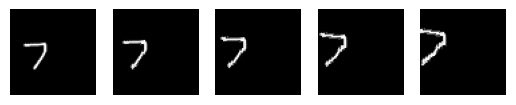

In [ ]:
show_images(ds._one_moving_digit())

torch.Size([5, 1, 64, 64])


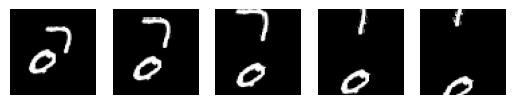

In [ ]:
digits = ds[0]
print(digits.shape)
show_images(digits)

In [ ]:
b = ds.get_batch(bs=32)
b.shape

torch.Size([32, 5, 1, 64, 64])

In [ ]:
b = ds.get_batch(512)

In [ ]:
import wandb
from time import perf_counter
from fastprogress import progress_bar

def cycle(bs=512, n=10):
    for _ in progress_bar(range(n), total=n):
        ti = perf_counter()
        b = ds.get_batch(bs)
        tf = perf_counter()
        print(f"Run took: {tf-ti:2.3f}s")
        if wandb.run is not None: wandb.log({"time_per_batch":tf-ti})

In [ ]:
config = dict(bs=512, n=10)

with wandb.init(project="miniai_ddpm", job_type="dataloader_perf", config=config):
    cycle(config["bs"], config["n"])

wandb: Currently logged in as: capecape. Use `wandb login --relogin` to force relogin


In [ ]:
ds.save(n_batches=10, bs=512)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
def cycle_dl(bs=512, n=10):
    dl = iter(DataLoader(torch.load("mmnist.pt"), batch_size=bs))
    for _ in progress_bar(range(n), total=n):
        ti = perf_counter()
        b = next(dl)
        tf = perf_counter()
        print(f"Run took: {tf-ti:2.3f}s")
        if wandb.run is not None: wandb.log({"time_per_batch":tf-ti})

In [ ]:
with wandb.init(project="miniai_ddpm", job_type="dataloader_perf", tags=["from_mem"], config=config):
    cycle_dl()

without concat

In [ ]:
ds.concat=False

In [ ]:
type(ds[0]), ds[0][0].shape

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()